In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import statsmodels.api as api
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("prices250.txt", sep='\s+', header=None, index_col=None)
df_100 = df.loc[0:100]

In [3]:
def get_pairs(df, n=5, verbose=False):
    P = np.zeros((100, 100))

    for i in range(100):
        if (i + 1) % 20 == 0 and verbose:
            print("%d instruments finished" % (i + 1))
        for j in range(100):
            _, p_value, _ = ts.coint(df[i], df[j])
            P[i, j] = p_value

    # 100 instruments, 250 past values takes 70 sec to loop through
    
    # take n smallest p values
    n = n
    np.fill_diagonal(P, 1)
    P_flat = P.flatten()
    index = np.argsort(P_flat)
    pairs = []
    candidates = []

    count = 0
    for idx in index[:500]:
        i = idx // 100
        j = idx - i * 100
        if i not in candidates and j not in candidates:
            pairs.append((i, j))
            candidates.append(i)
            candidates.append(j)

            count += 1
        if count >= n:
            break
    return pairs, P

In [4]:
pairs, P = get_pairs(df_100, verbose=True)

20 instruments finished
40 instruments finished
60 instruments finished
80 instruments finished
100 instruments finished


In [5]:
pairs

[(56, 98), (69, 79), (80, 66), (57, 71), (84, 91)]

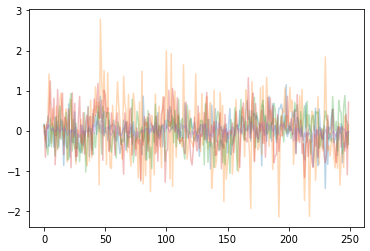

In [6]:
for i, j in pairs:
    Y = df[i]
    X = df[j]
    X = api.add_constant(X)
    result = api.OLS(Y, X).fit()

    coef = result.params[j]
    bias = result.params["const"]
    plt.plot(df[i].values - (coef * df[j].values + bias), alpha=0.3)